In [135]:
import numpy as np
import pymc3 as pm
import pickle

from tqdm import tqdm

from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.pymc3_models.base_model import produce_CIs, add_cms_to_plot

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
full_trace = pickle.load(open('traces/final_full.pkl', 'rb'))

Set Theano Environmental Variables for Parallelisation


In [6]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [37]:
from scipy.stats import nbinom
from scipy.signal import convolve

In [92]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]


In [184]:
def simulate_model(rg, CM_Alpha, full_trace, inferred_noise):
    r_i = data.Rs.index(f'{rg}')

    nS, nCMs = CM_Alpha.shape
    nD = len(data.Ds)

    ActiveCMRed = np.sum(data.ActiveCMs[r_i, :, : ].reshape((1, nCMs, nDs)) * CM_Alpha.reshape((nS, nCMs, 1)), axis=1)
    InitialSizeCases = full_trace['InitialSizeCases_log'][:, r_i]
    InitialSizeDeaths = full_trace['InitialSizeDeaths_log'][:, r_i]
    
    RegionR = full_trace['RegionR'][:, r_i]

    log_r = np.log(RegionR.reshape((nS, 1))) - ActiveCMRed
    gi_beta = full_trace['GI_mean'] / full_trace['GI_sd'] ** 2
    gi_alpha = full_trace['GI_mean'] ** 2 /full_trace['GI_sd'] ** 2

    if inferred_noise:
        growth_cases_noise = full_trace['GrowthCasesNoise'][:, r_i, :]
        growth_deaths_noise = full_trace['GrowthDeathsNoise'][:, r_i, :]
    else:
        growth_cases_noise = 0 * np.random.normal(0, 0.2, size=(nS, nD-40))
        growth_deaths_noise = 0 * np.random.normal(0, 0.2, size=(nS, nD-40))

    PsiCases = full_trace['PsiCases']
    PsiDeaths = full_trace['PsiDeaths']
    
    print(np.median(PsiCases))
    print(np.median(PsiDeaths))

    ExpectedGrowth = gi_beta.reshape((nS, 1)) * (np.exp(log_r / gi_alpha.reshape((nS, 1))) - np.ones_like(log_r))

    growth_cases = copy.deepcopy(ExpectedGrowth)
    growth_deaths = copy.deepcopy(ExpectedGrowth)

    growth_cases[:, 30:-10] += growth_cases_noise
    growth_deaths[:, 30:-10] += growth_deaths_noise

    infected_cases = np.exp(InitialSizeCases + np.cumsum(growth_cases, axis=-1))
    infected_deaths = np.exp(InitialSizeDeaths + np.cumsum(growth_deaths, axis=-1))

    cases_means = full_trace['CasesDelayMean']
    deaths_means = full_trace['DeathsDelayMean']
    cases_disps = full_trace['CasesDelayDisp']
    deaths_disps = full_trace['DeathsDelayDisp']

    expected_cases = np.zeros((nS, nD))
    expected_deaths = np.zeros((nS, nD))

    def discrete_nb_distribution(mean, disp, trunc):
        p = disp / (disp + mean)
        bins = np.arange(0, trunc)
        pmf = nbinom.pmf(bins, disp, p)
        pmf = pmf / np.sum(pmf)
        return pmf

    for i in range(nS):
        cases_delay = discrete_nb_distribution(cases_means[i], cases_disps[i], 32)
        deaths_delay = discrete_nb_distribution(deaths_means[i], deaths_disps[i], 48)
        expected_cases[i, :] = convolve(infected_cases[i, :], cases_delay, mode='full')[:nD]
        expected_deaths[i, :] = convolve(infected_deaths[i, :], deaths_delay, mode='full')[:nD]

    output_cases = np.zeros((nS, nD))
    output_deaths = np.zeros((nS, nD))
    for i in range(nS):
        mean_cases = expected_cases[i, :]
        p_cases = PsiCases[i] / (PsiCases[i] + mean_cases)
        cases = nbinom.rvs(PsiCases[i], p_cases)
        output_cases[i, :] = cases

        mean_deaths = expected_deaths[i, :]
        p_deaths = PsiDeaths[i] / (PsiDeaths[i] + mean_deaths)
        deaths = nbinom.rvs(PsiDeaths[i], p_deaths)
        output_deaths[i, :] = deaths
        
    return output_deaths, output_cases

In [185]:
def epicurve_plot(output_cases, output_deaths, data, title, r_i):
    data.unmask_all()
    data.mask_reopenings(print_out = False)
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]
    else:
        end_d_i = len(data.Ds)
    
    data.mask_region(data.Rs[r_i])
    start_d_i = 30
    
    means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(
       output_deaths
    )

    means_expected_cases, lu_ec, up_ec, _, _= produce_CIs(
        output_cases
    )
    
    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()

    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Recorded Daily Deaths",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        deaths.data,
        label="Heldout Daily Deaths (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:red",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )
    
    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Recorded Daily Confirmed Cases",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        cases.data,
        label="Heldout Daily Confirmed Cases (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:blue",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(title, fontsize=12)

In [186]:
class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]
        self.PsiCases = trace.PsiCases
        self.PsiDeaths = trace.PsiDeaths

3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051
3.4595316704462116
5.068695274243051


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


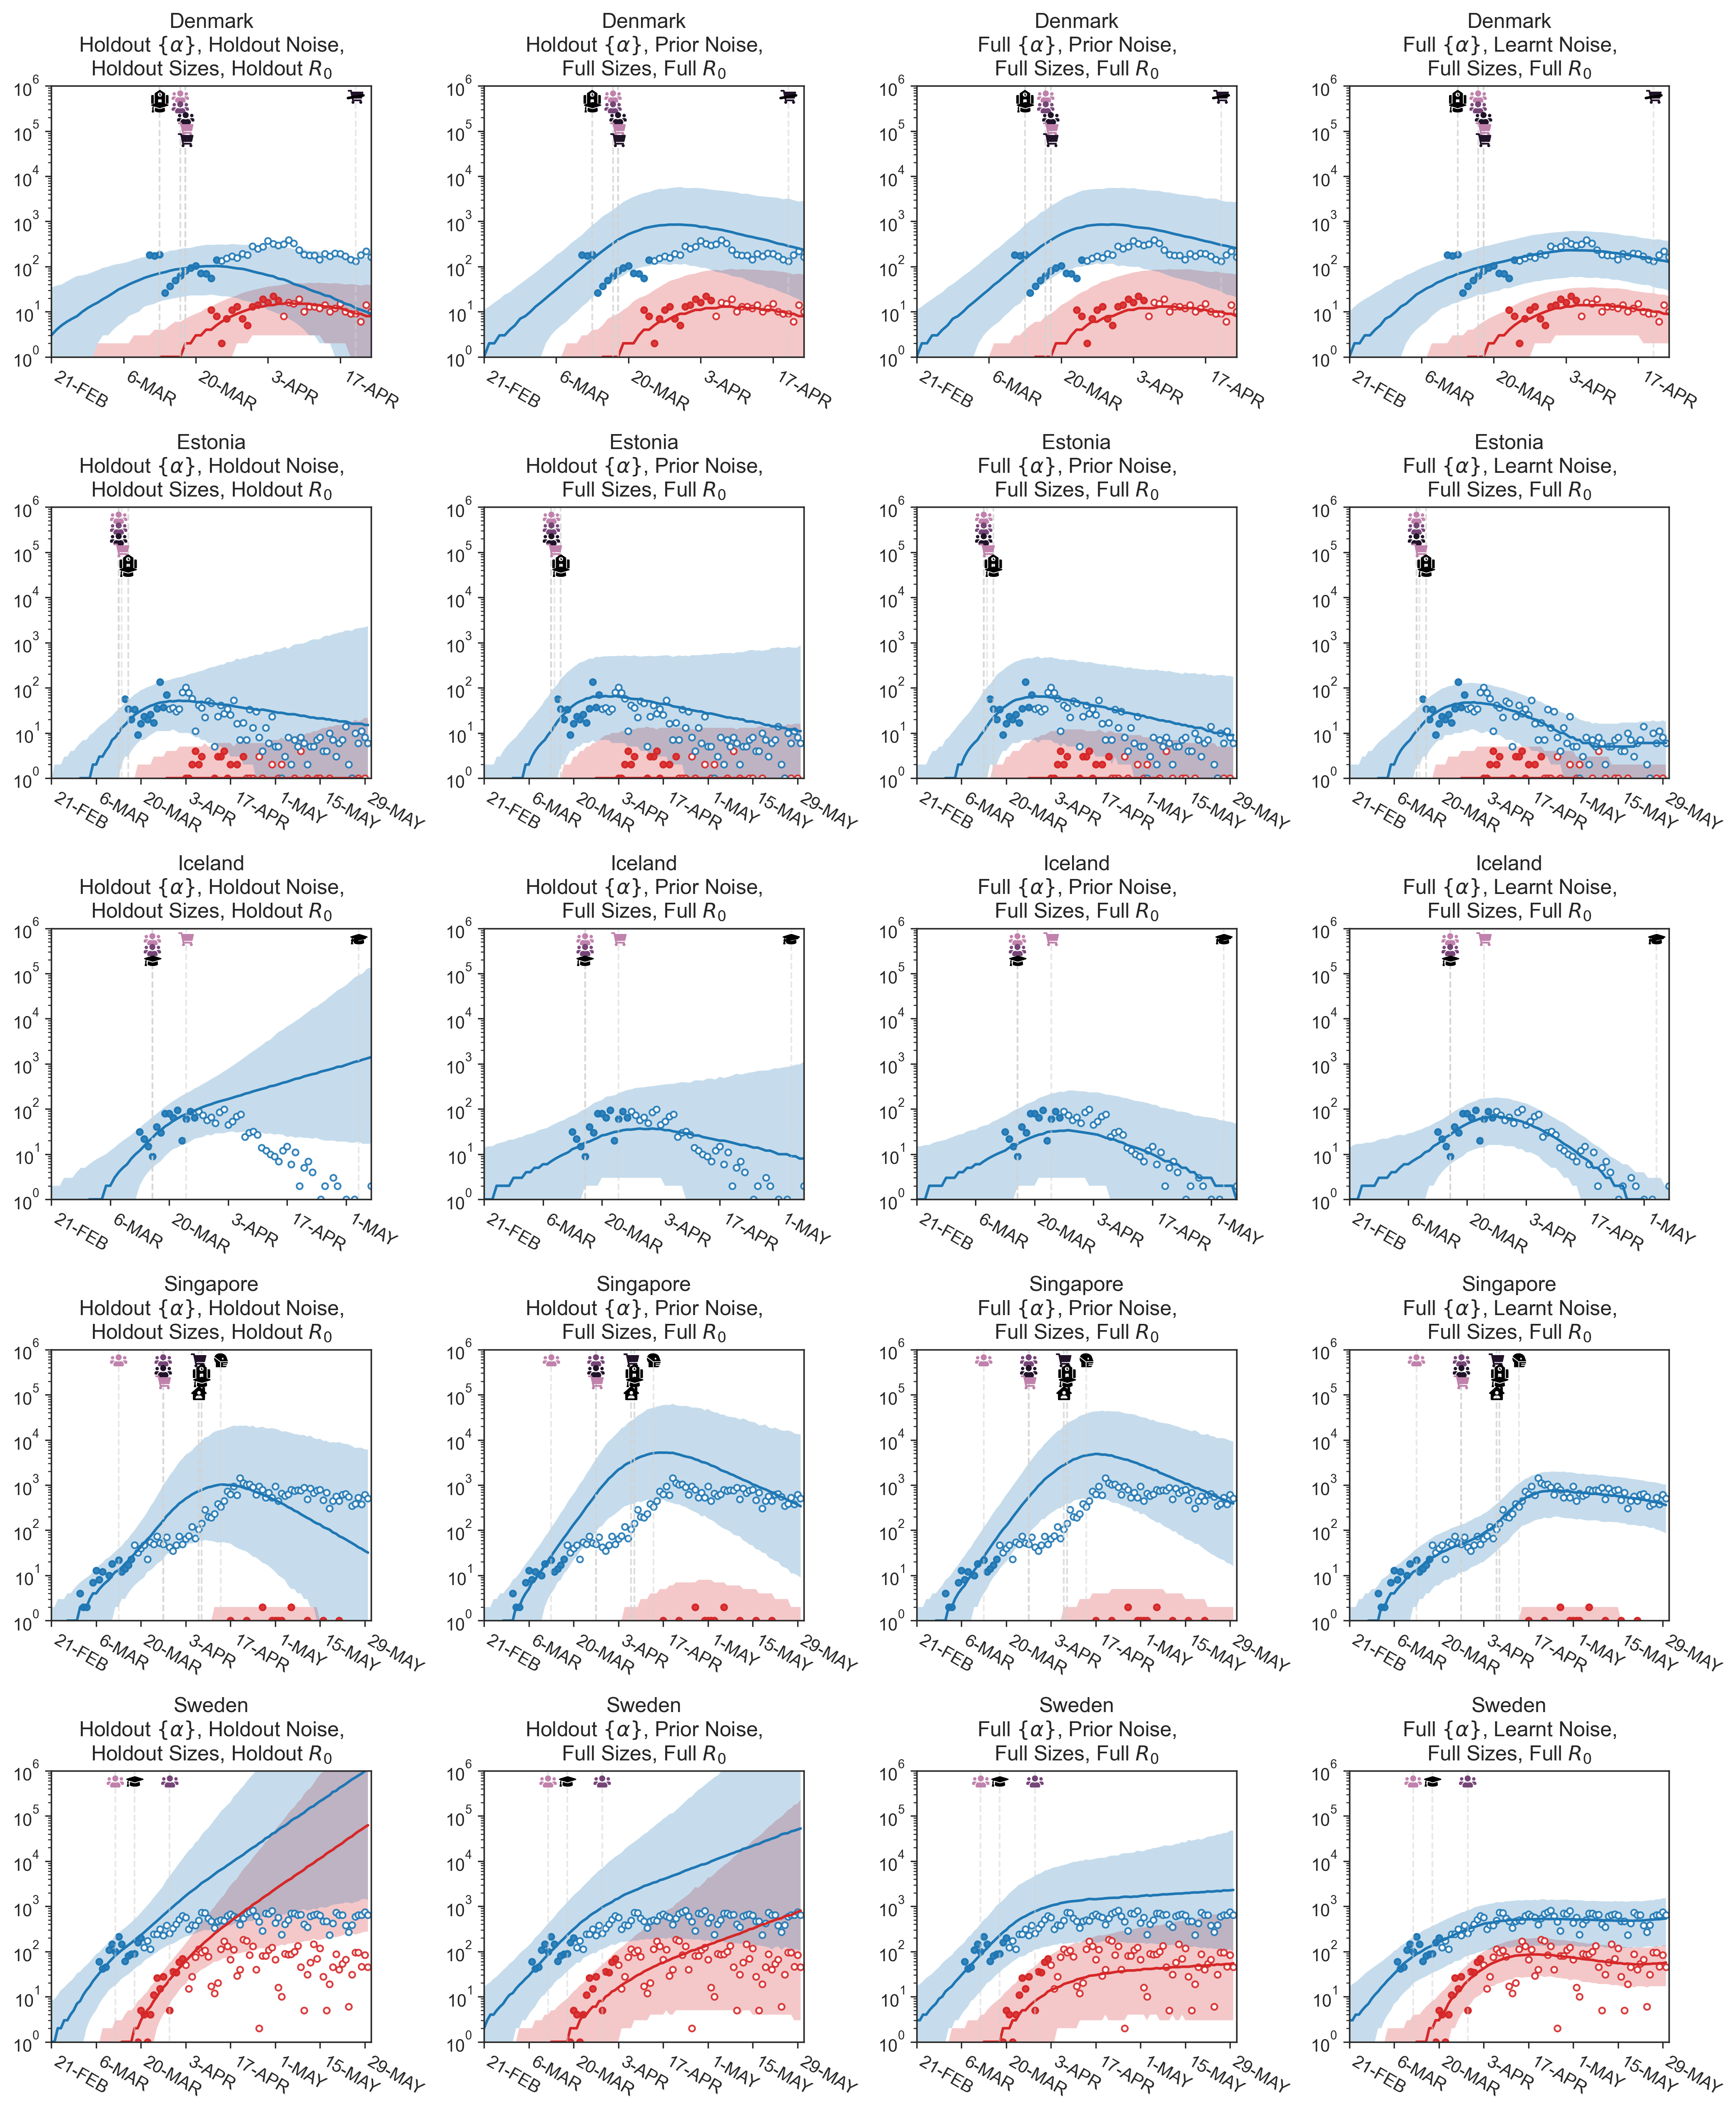

In [195]:
regions = ['DK', 'EE', 'IS', 'SG', 'SE']

plt.figure(figsize=(14, 17), dpi=300)
for row, rg in enumerate(regions):
    R_name = data.RNames[rg][0]
    r_i = data.Rs.index(rg)
    
    full_CM_Alpha = full_trace.CM_Alpha
    holdout_trace = pickle.load(open(f"../../server/sensitivity_default/region_holdout/{rg}.pkl", "rb"))
    holdout_CM_Alpha = - np.log(holdout_trace.CMReduction)
    
    plt.subplot(len(regions), 4, 4*row + 1)
    
    nS, nD = holdout_trace.ExpectedCases.shape
    output_cases = np.zeros((nS, nD))
    output_deaths = np.zeros((nS, nD))
    for i in range(nS):
        mean_cases = holdout_trace.ExpectedCases[i, :]
        p_cases = holdout_trace.PsiCases[i] / (holdout_trace.PsiCases[i] + mean_cases)
        cases = nbinom.rvs(holdout_trace.PsiCases[i], p_cases)
        output_cases[i, :] = cases

        mean_deaths = holdout_trace.ExpectedDeaths[i, :]
        p_deaths = holdout_trace.PsiDeaths[i] / (holdout_trace.PsiDeaths[i] + mean_deaths)
        deaths = nbinom.rvs(holdout_trace.PsiDeaths[i], p_deaths)
        output_deaths[i, :] = deaths
    
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nHoldout $\\{{\\alpha\\}}$, Holdout Noise,\nHoldout Sizes, Holdout $R_0$', r_i)
   
    plt.subplot(len(regions), 4, 4*row + 2)
    output_deaths, output_cases = simulate_model(rg, holdout_CM_Alpha, full_trace, False)
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nHoldout $\\{{\\alpha\\}}$, Prior Noise,\nFull Sizes, Full $R_0$', r_i)
   
    plt.subplot(len(regions), 4, 4*row + 3)
    output_deaths, output_cases = simulate_model(rg, full_CM_Alpha, full_trace, False)
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nFull $\\{{\\alpha\\}}$, Prior Noise,\nFull Sizes, Full $R_0$', r_i)
    
    plt.subplot(len(regions), 4, 4*row + 4)
    output_deaths, output_cases = simulate_model(rg, full_CM_Alpha, full_trace, True)
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nFull $\\{{\\alpha\\}}$, Learnt Noise,\nFull Sizes, Full $R_0$', r_i)
    
plt.tight_layout()
plt.savefig('figs/rebuttal/FigOverfit.pdf', bbox_inches='tight')

# infection counts

In [198]:
regions = ['FR', 'DE', 'SE', 'CH']

In [206]:
def infections_plot(trace, data, title, r_i):
    data.unmask_all()
    data.mask_reopenings(print_out = False)
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]
    else:
        end_d_i = len(data.Ds)
    
    start_d_i = 30
    
    means_expected_deaths_infected, lu_edi, up_edi, _, _ = produce_CIs(
       trace.InfectedDeaths[:, r_i, :]
    )

    means_expected_cases_infected, lu_eci, up_eci, _, _= produce_CIs(
        trace.InfectedCases[:, r_i, :]
    )
    
    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()

    plt.plot(
        days_x,
        means_expected_deaths_infected,
        label="Daily Infections -\n Later Deaths",
        zorder=2,
        color="tab:orange"
    )

    plt.fill_between(
        days_x, lu_edi, up_edi, alpha=0.25, color="tab:orange", linewidth=0
    )

    plt.plot(
        days_x,
        means_expected_cases_infected,
        label="Daily Infections -\n Later Confirmed",
        zorder=2,
        color="tab:purple"
    )

    plt.fill_between(
        days_x, lu_eci, up_eci, alpha=0.25, color="tab:purple", linewidth=0
    )
    
    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(title, fontsize=12)
    return ax 

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


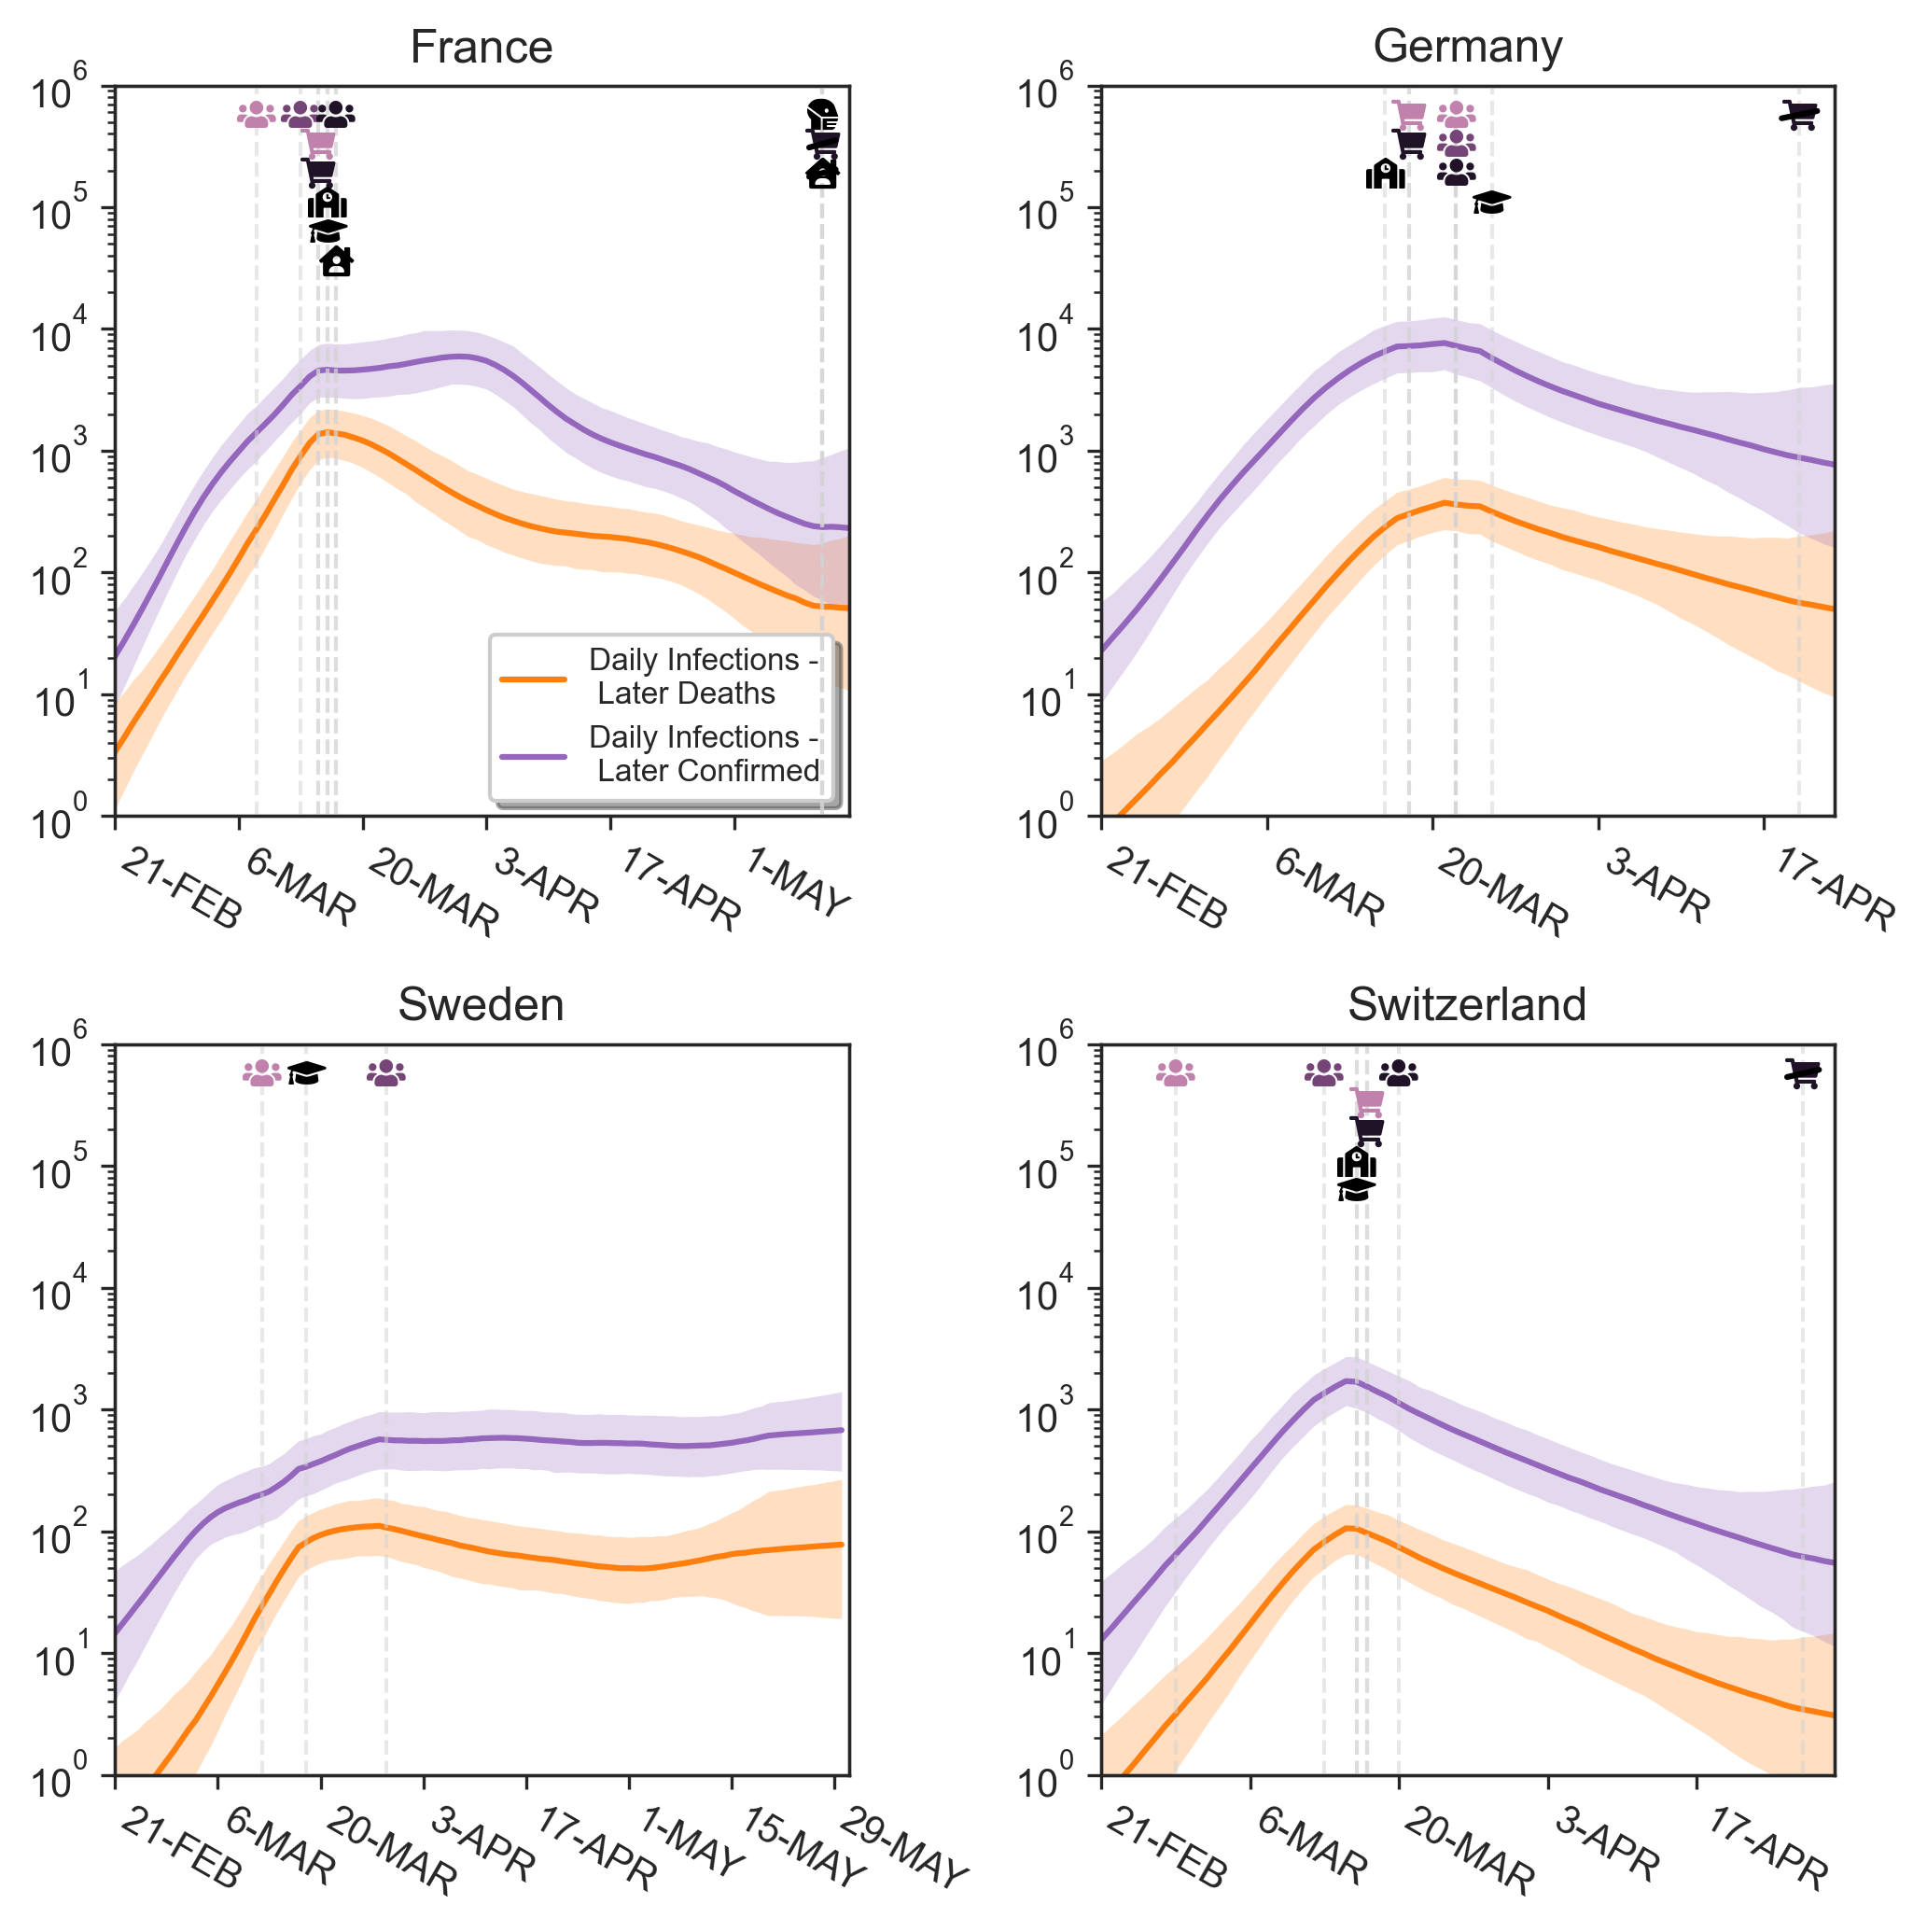

In [208]:
plt.figure(figsize=(7, 7), dpi=300)
for row, rg in enumerate(regions):
    R_name = data.RNames[rg][0]
    r_i = data.Rs.index(rg)
    
    plt.subplot(2, 2, row+1)
    ax = infections_plot(full_trace, data, data.RNames[rg][0], r_i)
    
    if row == 0:
        ax.legend(shadow=True, fancybox=True, fontsize=8, loc='lower right')
    
plt.tight_layout()
plt.savefig('figs/rebuttal/infection_counts.pdf', bbox_inches='tight')